# Using Rascal to Calculate SOAP Vectors

This notebook is intended as an introductory how-to on calculating the SOAP vector and train a model for their atomization energies on these vectors. For more information on the variable conventions, derivation, utility, and calculation of SOAP vectors, please refer to (among others): 
- [On representing chemical environments (Bartók 2013)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.87.184115)
- [Gaussian approximation potentials: A brief tutorial introduction (Bartók 2015)](https://onlinelibrary.wiley.com/doi/full/10.1002/qua.24927)
- [Comparing molecules and solids across structural and alchemical space (De 2016)](https://pubs.rsc.org/en/content/articlepdf/2016/cp/c6cp00415f)

Beyond libRascal, the packages used in this tutorial are:  [json](https://docs.python.org/2/library/json.html), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), and [ase](https://wiki.fysik.dtu.dk/ase/index.html).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from tutorial_utils import *
try:
    from rascal.representations import SphericalInvariants as SOAP
except:
    from rascal.representations import SOAP
readme_button()

Button(description='Show README', style=ButtonStyle())

Output()

### First, let's look at how we can use SOAP to represent small molecules.
We will play around with the SOAP hyperparameters in later examples, but for now we'll use the default hyperparameters.

In [2]:
mySOAP=SOAP_tutorial()
mySOAP.output_params()

Our input file is small_molecules-1000.xyz, of which we are using 197 frames.

<br/>Our hyperparameters are <table>  <thead><tr><th>Parameter</th><th>Value</th></tr></thead><tbody><tr><td>Body Order</td><td>PowerSpectrum</td></tr><tr><td>$r_{cut}$</td><td>3.5</td></tr><tr><td>$n_{max}$</td><td>2</td></tr><tr><td>$l_{max}$</td><td>1</td></tr><tr><td>$\sigma$</td><td>0.5</td></tr></tbody></table>

Now let's look at the SOAP representation of our first frame

In [3]:
soap = SOAP(**mySOAP.hyperparameters)
X = soap.transform(mySOAP.frames[:1])

mySOAP.verbosity_wrap("Our first frame has {} environments, thus our soap feature matrix has a shape of {}".format(len(mySOAP.frames[0].positions), X.get_feature_matrix().T.shape, len(X.get_feature_matrix().T[0])))

Our first frame has 17 environments, thus our soap feature matrix has a shape of (17, 80)

### Now we know how to retrieve SOAP vectors, let's look at the impact of the hyperparameters on training a Kernel Ridge Regression (KRR)
This time when we open up the tutorial, you will be able to change the input file, hyperparameters, and property to use for the kernel ridge regression, which are saved to mySOAP as they are changed. We've even included some suggestions for hyperparameters, why not try the Power Spectrum first?

In [6]:
mySOAP=SOAP_tutorial(interactive=True)

ToggleButtons(description='Input File: ', options=('small_molecules-1000.xyz', 'CSD-500.xyz'), style=ToggleBut…

ToggleButtons(description='SOAP Presets: ', options=('Power Spectrum', 'Full Power Spectrum', 'Radial Spectrum…

IntSlider(value=197, description='Number of Frames', max=985, style=SliderStyle(description_width='initial'))

Dropdown(description='Property to ML', options=('dft_formation_energy_per_atom_in_eV',), style=DescriptionStyl…

Dropdown(description='Body Order', options=('PowerSpectrum', 'RadialSpectrum'), style=DescriptionStyle(descrip…

FloatSlider(value=3.5, description='$r_{cut}$', max=5.0, min=2.0, step=0.15, style=SliderStyle(description_wid…

IntSlider(value=2, description='$n_{max}$', max=10, style=SliderStyle(description_width='initial'))

IntSlider(value=1, description='$l_{max}$', max=10, style=SliderStyle(description_width='initial'))

FloatSlider(value=0.5, description='$\\sigma$', max=1.0, step=0.05, style=SliderStyle(description_width='initi…

In [13]:
mySOAP.properties["CS"].shape

(500,)

In [14]:
mySOAP.train_krr_model()

Our input file is CSD-500.xyz, of which we are using 223 frames.

<br/>Our hyperparameters are <table>  <thead><tr><th>Parameter</th><th>Value</th></tr></thead><tbody><tr><td>Body Order</td><td>PowerSpectrum</td></tr><tr><td>$r_{cut}$</td><td>3.5</td></tr><tr><td>$n_{max}$</td><td>6</td></tr><tr><td>$l_{max}$</td><td>6</td></tr><tr><td>$\sigma$</td><td>0.4</td></tr></tbody></table>

<br/>We will now train a model on CS.

First, I am going to separate my dataset:

<table>  <thead><tr><th>Partition</th><th>Number of Frames</th><th>Percentage</th></tr></thead><tbody><tr><td>Training Set</td><td>178</td><td>80</td></tr><tr><td>Testing Set</td><td>45</td><td>20</td></tr></tbody></table>

<br/>Now we will compute the SOAP representation of our training frames.

This took 0.01183626 seconds/frame.

<br/>Next we find the kernel for our training model.<br/>(This step may take a few minutes for larger training sets.)

<br/>We will adjust the diagonals of our kernel by 2e-08 so that it is properly scaled.

<br/>Now we can take this kernel to compute the weights of our KRR.

<table>  <thead><tr><th>Statistic</th><th>Value</th></tr></thead><tbody><tr><td>SUP</td><td>117.30808051400622</td></tr><tr><td>MAE</td><td>8.71309380057964</td></tr><tr><td>RMSD</td><td>16.07519301703492</td></tr><tr><td>$R^2$</td><td>0.9526793305970386</td></tr></tbody></table>

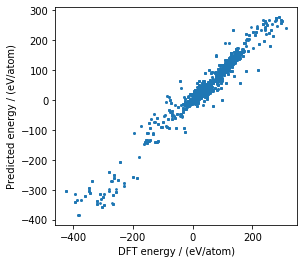

In [15]:
mySOAP.plot_prediction()

## Now that we've explained the workflow, let's strip away the SOAP_tutorial wrapper and run the computation again:

In [ ]:
from ase.io import read
import numpy as np
try:
    from rascal.representations import SphericalInvariants as SOAP
except:
    from rascal.representations import SOAP

def split_dataset(N, training_percentage, seed=20):
    np.random.seed(seed)
    ids = list(range(N))
    np.random.shuffle(ids)
    return ids[:int(training_percentage*N)], ids[int(training_percentage*N):]

class KRR(object):
    def __init__(self, zeta, weights, representation, X, kernel_type):
        self.weights = weights
        self.representation = representation
        self.zeta = zeta
        self.X = X
        self.kernel_type=kernel_type

    def predict(self,frames):
        features = self.representation.transform(frames)
        kernel_function = self.X.cosine_kernel_atomic if self.kernel_type=='atomic' else self.X.cosine_kernel_global
        kernel = kernel_function(features, zeta) 
        return np.dot(self.weights, kernel)

### These are the parameters you'll want change, such as we did above with the sliders.
(Everything else in the workflow is a function of these parameters)

In [ ]:
input_file = 'data/small_molecules-1000.xyz'
hyperparameters = dict(soap_type = 'PowerSpectrum', \
                       interaction_cutoff = 3.5, \
                       max_radial = 2, \
                       max_angular = 1, \
                       gaussian_sigma_constant = 0.5, \
                       gaussian_sigma_type = 'Constant', \
                       cutoff_smooth_width = 0.0
                      )
property_to_ml = "dft_formation_energy_per_atom_in_eV"

training_percentage = 0.8
zeta = 2
Lambda = 5e-3
jitter=1e-8

### Which are then used to compute:

In [ ]:
frames = np.array(read(input_file,":"))
number_of_frames = len(frames)
representation = SOAP(**hyperparameters)
property_values = np.array([cc.info[property_to_ml] for cc in frames])
train_idx, test_idx = split_dataset(number_of_frames, training_percentage)
features = representation.transform(frames[train_idx])

### Then, you can construct the kernel for ML and feed it into a KRR Model:

In [ ]:
kernel_function = features.cosine_kernel_atomic if property_to_ml == "ENERGY" else features.cosine_kernel_global
kernel = kernel_function(zeta)

delta = np.std(property_values[train_idx]) / np.mean(kernel.diagonal())
kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
weights = np.linalg.solve(kernel,property_values[train_idx])

In [ ]:
model = KRR(zeta, weights, representation, features, kernel_type='atomic' if property_to_ml=="ENERGY" else "global")

### This model can be in turn used to predict the data from out testing set:

In [ ]:
y_pred = model.predict(frames[test_idx])
print(dict(
        mean_average_error= [np.mean(np.abs(y_pred-property_values[test_idx]))],
        root_mean_squared_error=[np.sqrt(np.mean((y_pred-property_values[test_idx])**2))],
        R2 = [np.mean(1 - (((property_values[test_idx] - y_pred) ** 2).sum(axis=0,dtype=np.float64) / ((property_values[test_idx] - np.average(property_values[test_idx], axis=0) ** 2).sum(axis=0,dtype=np.float64))))]
        ))
plt.scatter(y_pred, property_values[test_idx], s=3)
plt.axis('scaled')
plt.xlabel('DFT energy / (eV/atom)')
plt.ylabel('Predicted energy / (eV/atom)')
plt.gca().set_aspect('equal')